<a href="https://colab.research.google.com/github/jwoonge/ML-projects/blob/master/10/assignment_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Optimal Selection of the hyper-parameters associated with the classification on MNIST
20141261 송제웅  
<hr>  

## 0. Import library
---
import library

In [1]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import matplotlib.pyplot as plt

## 1. DownLoad and Normalize dataset (MNIST)
---  

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081,)),
])

data_path = './MNIST'
data_train = datasets.MNIST(root = data_path, train = False, download = True, transform = transform)
data_test = datasets.MNIST(root = data_path, train = True, download = True, transform = transform)


## 2. Design NN Model
---
three fully connected layers with an activation function of sigmoid, LogSoftmax

In [3]:
class classification(nn.Module):
    def __init__(self):
        super(classification, self).__init__()
        self.classifier1 = nn.Sequential(
            nn.Linear(in_features=28*28, out_features=128),
            nn.Softsign()
        )
        
        self.classifier2 = nn.Sequential(
            nn.Linear(in_features=128, out_features=128),
            nn.Softsign()
        )
        
        self.classifier3 = nn.Sequential(
            nn.Linear(in_features=128, out_features=10),
            nn.LogSoftmax(dim=1),
        )
        
    def forward(self, inputs):
        x = inputs.view(inputs.size(0), -1)
        x = self.classifier1(x)
        x = self.classifier2(x)
        out = self.classifier3(x)
        return out

## 3. Define functions for learning
---

In [4]:
def train(model, data_train, data_train_batch, optimizer, criterion, device='cuda'):
    model.train()
    n_batch = 0
    avg_loss = 0
    avg_acc = 0
    for batch_idx, (x, y) in enumerate(data_train_batch):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        pred = model.forward(x)
        loss = criterion(pred, y)
        avg_loss += loss.item()
        avg_acc += accuracy(pred, y)
        n_batch += 1

        loss.backward()
        optimizer.step()

    avg_loss /= n_batch
    avg_acc /= n_batch
    return avg_loss, avg_acc

def test(model, x, y, criterion):
    model.eval()
    with torch.no_grad():
        pred = model.forward(x)
        loss = criterion(pred, y).item()
        acc = accuracy(pred, y)
    return loss, acc

def accuracy(pred, y):
    correct_cnt = 0
    num_sample = len(y)
    for i in range(num_sample):
        pred_class = pred[i].argmax()
        if y[i]==pred_class:
            correct_cnt += 1
    return 100 * correct_cnt / num_sample


In [5]:
def learn(model, data_train, data_test, criterion, optimizer, batch_size, epoch, device='cuda'):
    data_train_batch = torch.utils.data.DataLoader(data_train, batch_size, shuffle=True)
    test_x, test_y = data_test.test_data.view((60000,28*28)), data_test.test_labels
    test_x, test_y = torch.tensor(test_x, dtype=torch.float, device=device), test_y.to(device)
    #loss_train_s = []; loss_test_s = []; acc_train_s = []; acc_test_s = []
    i = 0
    while i<epoch:
        losstest, acctest = test(model, test_x, test_y, criterion)
        losstrain, acctrain = train(model, data_train, data_train_batch, optimizer, criterion, device)
        loss_train.append(losstrain); loss_test.append(losstest)
        acc_train.append(acctrain); acc_test.append(acctest)
        i += 1
        print(i,'\t', losstrain,'\t', acctrain,'\t', losstest,'\t', acctest)
        

In [6]:
is_cuda = torch.cuda.is_available()
device = torch.device('cuda' if is_cuda else 'cpu')


## 4. Learn
---

In [ ]:
global loss_train, loss_test, acc_train, acc_test
loss_train = []; loss_test = []; acc_train = []; acc_test = []
classifier = classification().to(device)
criterion = nn.NLLLoss()
print('phase 1')
while True:
    optimizer = torch.optim.SGD(classifier.parameters(), lr=1, weight_decay=0.0015)
    learn(classifier, data_train, data_test, criterion, optimizer, 32, 1, device)
    if acc_test[-1] > 91:
        break
print('phase 2')
while True:
    optimizer = torch.optim.SGD(classifier.parameters(), lr=0.1, weight_decay=0.0020)
    learn(classifier, data_train, data_test, criterion, optimizer, 32, 1, device)
    if acc_test[-1] > 94:
        break
print('phase 3')

optimizer = torch.optim.SGD(classifier.parameters(), lr=0.05, weight_decay=0.0020)
learn(classifier, data_train, data_test, criterion, optimizer, 10000, 10, device)

while True:
    optimizer = torch.optim.SGD(classifier.parameters(), lr=0.05, weight_decay=0.0020)
    learn(classifier, data_train, data_test, criterion, optimizer, 10000, 1, device)
    if loss_test[-1] >= loss_test[-2]:
        break


---  
# RESULTS
---  
## 1. Plot the training and testing losses over epochs
---

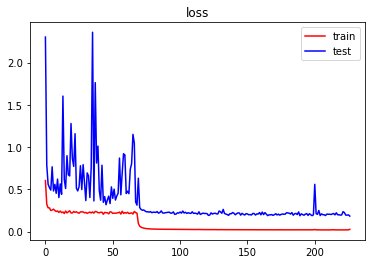

In [26]:
plt.plot(loss_train, color='r')
plt.plot(loss_test, color='b')
plt.title('loss')
plt.legend(['train','test'])
plt.show()

## 2. Plot the training and testing accuracies over epochs
---


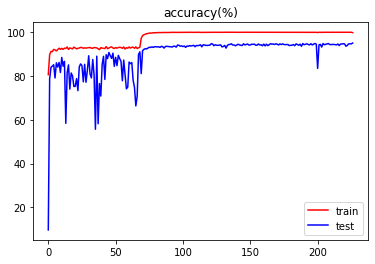

In [27]:
plt.plot(acc_train, color='r')
plt.plot(acc_test, color='b')
plt.title('accuracy(%)')
plt.legend(['train','test'])
plt.show()

## 3. Print the final training and testing losses at convergence
---

In [28]:
print('training loss\t',loss_train[-1])
print('testing loss\t',loss_test[-1])

training loss	 0.028324566903515175
testing loss	 0.18422451615333557


## 4. Print the final training and testing accuracies at convergence
---

In [29]:
print('training accuracy\t',acc_train[-1])
print('testing accuracy\t',acc_test[-1])

training accuracy	 99.810303514377
testing accuracy	 95.055
